In [7]:
using Plots
gr()

Plots.GRBackend()

In [8]:
function forces(x) #x = (x,y,theta,deltav,deltag,v,w)
     
    theta   = x[3];
    deltav  = x[4];
    deltag  = x[5];
    vitesse = x[6];
    omega   = x[7];
    
    fv = alphav * V * cos(theta+deltav) - alphav * vitesse * sin(deltav)
    fg = alphag * vitesse * sin(deltag)
    
    return fv, fg
end

function f(x,u) #x = (x,y,theta,deltav,deltag,v,w)
     
    theta   = x[3];
    deltav  = x[4];
    deltag  = x[5];
    vitesse = x[6];
    omega   = x[7];
    fv, fg  = forces(x, V, 0.);
    
    Dx = [vitesse * cos(theta),
          vitesse * sin(theta) - beta * V,
          omega,    
          u[1],
          u[2],
          (1/m) * (fv * sin(deltav) - fg * sin(deltag) - vitesse * alphaf),
          (1/J) * ((L - rv * cos(deltav)) * fv - rg * fg * cos(deltag) - alphatheta * omega)];
    
    return Dx
end

function arg(a,theta)  #calcule theta1, le + proche de a, tq theta1=theta+2k*pi
    
    k = round((a - theta) / (2*π)); 
    theta1 = theta + 2 * k * π;
end  

function r(x,w)
    
    theta   = x[3];
    deltav  = x[4];
    deltag  = x[5];
    vitesse = x[6];
    omega   = x[7];
    fv, fg  = forces(x);
    
    D1theta   = omega;
    
    D1vitesse = (1/m) * ( fv * sin(deltav) - fg * sin(deltag) - vitesse * alphaf);
    
    D1omega   = (1/J) * ((L - rv * cos(deltav)) * fv - rg * fg * cos(deltag) - alphatheta * omega);
    
    A1 = [1 0; (rv/J) * fv * sin(deltav) (rg/J) * fg * sin(deltag)];
    
    A2 = [0 0; L/J - rv/J * cos(deltav) -rg/J * cos(deltag)];
    
    A3 = [-alphav * (V * sin(theta+deltav) + vitesse * cos(deltav)) 0; 0 alphag * vitesse * cos(deltag)];
    
    b1 = [0, -alphatheta/J * D1omega];
    
    b2 = [-alphav * (V * omega * sin(theta+deltav) + D1vitesse * sin(deltav)), alphag * D1vitesse * sin(deltag)];
    
    A  = A1 + A2 * A3;
    
    b  = A2 * b2 + b1;
    
    u  = inv(A) * ((w - [deltav, theta + 3 * omega + 3 * D1omega]) - b);
    
    return u
end

function ouverture(cap)
   
    return π * (floor((cap + π/2)/(2 * π))) + π/4 - cap/2
end

function automate(cap, q, x, tq)
    
    a   = 30; 
    tq1 = 5;
    tq  = tq + dt;
    
    if (tq>tq1) && (q==3) && (x[1] - xd > a) 
        q=4; tq=0; 
    end  #3->4
    
    if (tq>tq1) && (q==4) && (x[1] - xd < -a) 
        q=3; tq=0; 
    end  #4->3
    
    if (tq>tq1) && (q==3) && (x[2] - yd > a) 
        q=1; tq=0; 
    end #3->1
    
    if (tq>tq1) && (q==1) && (x[2] - yd < -a) 
        q=3; tq=0; 
    end #1->3
    
    if (tq>tq1) && (q==1) && (x[1] - xd > a) 
        q=2; tq=0;
    end #1->2
    
    if (tq>tq1) && (q==2) && (x[1] - xd < -a) 
        q=1; tq=0; 
    end #2->1
    
    if (tq>tq1) && (q==4) && (x[2] - yd > a) 
        q=2; tq=0; 
    end #4->2
    
    if (tq>tq1) && (q==2) && (x[2] - yd < -a) 
        q=4; tq=0; 
    end #2->4
    
    if q == 1
        cap1=arg(cap,7*π/4)
    elseif q == 2
        cap1=arg(cap,5*π/4)
    elseif q == 3
        cap1=arg(cap,π/6)
    elseif q == 4
        cap1=arg(cap,5*π/6)
    end
    
    cap = cap + (cap1 - cap) * dt
    return cap, q, tq
end

function sail_ref(ψref)
    
    δsref = π * floor( ψref / (2*π) + 1/4) + π/4 - ψref/2
    δsref = atan2(sin(δsref), cos(δsref))
    
    return δsref
end

function heading_ref(q, xd, yd, ψref, x, y, tq) #(cap, q, x, tq)
   
    a = 30;
    
    if (q==3) && ((x-xd)>a)
        q = 4
    end
    
    if (q==4) && ((xd-x)>a)
        q = 3
    end
    
    if (q==3) && ((y-yd)>a)
        q = 1
    end
    
    if (q==1) && ((yd-y)>a)
        q = 3
    end
    
    if (q==1) && ((x-xd)>a)
        q = 2
    end
    
    if (q==2) && ((xd-x)>a)
        q = 1
    end
    
    if(q==4) && ((y-yd)>a)
        q = 2 
    end
    
    if(q==2) && ((yd-y)>a)
        q = 4
    end
    
    if q == 1
        ψref_tmp = 7*pi/4
    elseif  q ==2
        ψref_tmp = 5*pi/4
    elseif q == 3
        ψref_tmp = pi/6
    elseif q == 4
        ψref_tmp = 5*pi/6
    end
    
    ψref_tmp = ψref_tmp + 2 * π * round((ψref - ψref_tmp) / (2*π))
    ψref = ψref + (ψref_tmp - ψref) * dt
    #ψref = atan2(sin(ψref), cos(ψref))
    
    return ψref, q, tq    
end

heading_ref (generic function with 1 method)

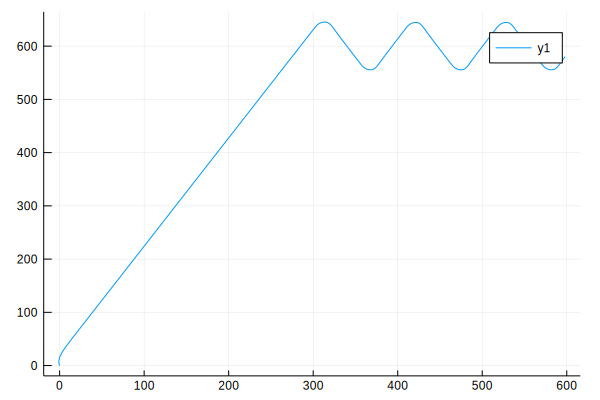

In [12]:
global xd 
global yd 
global V 
global ech 
global tq

βb = 0.05   #boat’s drift coefficient
cfw_l = 60.  #water friction
cfw_a = 500. #water angular friction
λs  = 500.  #lift coefficient of the sail
λr  = 300.  #lift coefficient of the rudder
ρmc = 1.    #distance between the mast and the center of the sail
ρgm = 1.    #distance between the boat’s center of gravity and the mast
ρgr = 2.    #distance between G and the rudder
m   = 1000. #total mass of the boat (including the added-mass)
Jz  = 2000. #moment of inertia

xd=600.;
yd=600.;
tq=0.;
ech=60;
q=1;
L=1;            #distance mat-centre de poussée de la voile
alphaf=60;      #frottement de l'eau
alphatheta=500; #frottement angulaire de l'eau
alphav=500;     #portance de la voile
alphag=15*20;   #portance du gouvernail
beta=0.05;      #dérive du bateau
rv=1;           #distance de G au mat
rg=2;           #distance de G au gouvernail 
V=10.;           #vent (m/sec)
m=1000;         #masse du bateau en kg
J=2000;         #moment d'inertie
x0=[0., 0., deg2rad(0.), 0, 0.0, 2, 0]; #x = (x,y,theta,deltav,deltag,v,w)
x=x0;
cap=x[3];
t=0;dt=0.01;

vw = V
ϕw = 0. * π/2
vc = 3.5
ϕc = 0.25

x_ = [x[1]]
y_ = [x[2]]
ψ_ = [x[3]]
δs_ = [x[4]]
δr_ = [x[5]]
u_ = [x[6]]
r_ = [x[7]]
δsref = [0.]
ψref = [0.]

err = norm([x_[end], y_[end]] - [xd, yd])
t  = 0. 
dt = 0.1
while err > 20. && t < 550.
    
    t = t + dt;
    cap, q, tq = heading_ref(q, xd, yd, cap, x[1], x[2], tq)
    w          = [sail_ref(cap), cap];
    u          = r(x,w);
    x          = x + f(x,u) * dt;
    
    push!(x_, x[1])
    push!(y_, x[2])
    push!(ψ_, x[3])
    push!(δs_, x[4])
    push!(δr_, x[5])
    push!(u_, x[6])
    push!(r_, x[7])
    
    push!(δsref, w[1])
    push!(ψref, w[2])
    
    
    err = norm([x_[end], y_[end]] - [xd, yd])
end

plot(y_, x_)

In [ ]:
plot([ ψ_, ψref]*180/π)

In [ ]:
find(abs.(ψref).>π)

In [ ]:
ψref[1206]*180/π
atan2(sin(ψref[1206]), cos(ψref[1206]))*180/π